In [1]:
# This version is changing the similarity thershold for cosine

In [2]:

import zipfile
import os
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import xml.etree.ElementTree as ET
import tensorflow as t
import torch
import statistics


2024-07-11 19:26:12.107003: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-11 19:26:12.110292: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-11 19:26:12.157479: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-11 19:26:13.026392: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Unzipping csv file

In [3]:

uploaded_zip = '/home/claney/EclipsePlatform/eclipse_platform.zip'
extract_dir = '/home/claney/extracted'
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)
with zipfile.ZipFile(uploaded_zip, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

csv_file = os.path.join(extract_dir, 'eclipse_platform.csv')
full_df = pd.read_csv(csv_file)

In [4]:
full_df.fillna(0,inplace=True)

# Spliting testing and training

In [5]:
length=len(full_df)
split_index=int(.8*length)
df=full_df.iloc[:split_index] #df=training set


# Creating isDuplicate column

In [6]:
def is_duplicate(val):
    return 1 if val !=0.0 else 0
df['isDuplicate'] = df['Duplicated_issue'].apply(lambda x: is_duplicate(x))

print(df['isDuplicate'])

0        0
1        0
2        0
3        0
4        0
        ..
68119    0
68120    0
68121    0
68122    0
68123    0
Name: isDuplicate, Length: 68124, dtype: int64


/tmp/ipykernel_124509/1537637410.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['isDuplicate'] = df['Duplicated_issue'].apply(lambda x: is_duplicate(x))


isDuplicate
0    56126
1    11998
Name: count, dtype: int64


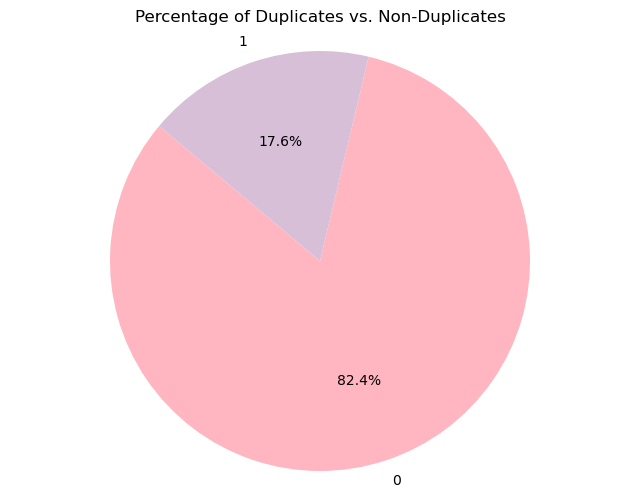

In [7]:
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and 'isDuplicate' is the column indicating duplicates
duplicate_counts = df['isDuplicate'].value_counts()

# Check the contents of duplicate_counts
print(duplicate_counts)

# Create a list of labels matching the length of duplicate_counts
# Ensure the labels match the values in the 'isDuplicate' column
labels = duplicate_counts.index.tolist()

# Define colors (length should match number of unique values in 'isDuplicate')
colors = ['#FFB6C1', '#D8BFD8'][:len(labels)]

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(duplicate_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Percentage of Duplicates vs. Non-Duplicates')
plt.axis('equal')
plt.show()


# Preprocessing

In [8]:
df['Description'] = df['Description'].astype(str).fillna('')

/tmp/ipykernel_124509/77102330.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Description'] = df['Description'].astype(str).fillna('')


In [9]:
#creating freeform textual data column
df['full_text_data']=df['Description']+df['Title']
print(df['full_text_data'])
df['full_text_data']=df['full_text_data'].fillna('')

0        - Setup a project that contains a *.gif resour...
1        Opening repository resource always open the de...
2        KM (10/2/2001 5:55:18 PM); \tThis PR about the...
3        - become synchronized with some project in a r...
4        For getting/setting the managed state of a res...
                               ...                        
68119    Build ID: 3.3 (I am not sure what You mean by ...
68120    There are several NPEs within the UI session t...
68121    I20080501-0100; ; Now that were using the coll...
68122    Created attachment 98318; screenshot; ; I20080...
68123    Build ID: M20080221-1800; ; Steps To Reproduce...
Name: full_text_data, Length: 68124, dtype: object


/tmp/ipykernel_124509/3345744263.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['full_text_data']=df['Description']+df['Title']
/tmp/ipykernel_124509/3345744263.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['full_text_data']=df['full_text_data'].fillna('')


# Creating topics using LDA

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer
count_vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words='english')

# Fit and transform the CountVectorizer on the text data
counts = count_vectorizer.fit_transform(df['full_text_data'])

count_vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words='english')
counts = count_vectorizer.fit_transform(df['full_text_data'])

        # Fit LDA model
lda = LatentDirichletAllocation(n_components=7, max_iter=10,learning_method='online',learning_offset=50.,random_state=0)
lda.fit(counts)


LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          n_components=7, random_state=0)

In [11]:
feature_names = count_vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-20 - 1:-1]]))
        
        print()

Topic 1:
framework junit dylib tests thread versions frameworks test com library apple testsuite 4xestacktrace libclient uitestapplication testresult testcase carbon 0010 remotetestrunner

Topic 2:
eclipse org core osgi update framework plugins message ui com jar bundle platform help equinox http ibm runtime apache entry

Topic 3:
swt new shell display line string public table int event import eclipse null object void org tree image item return

Topic 4:
lib eclipse 03 00000000 usr dll 00 object jar xp system32 org java windows lang plugins rwxp jre 08 02

Topic 5:
java org eclipse internal ui core swt run widgets main workbench jface display runtime lang method widget reflect launcher invoke

Topic 6:
editor text view open window line click dialog help search page menu select perspective tab does button ctrl editors right

Topic 7:
file project build eclipse new cvs error view workspace files use dialog using does bug problem create user set like



In [12]:
#for alll columns in the df 
#compare each bug report to each topic 
#if
topic_distributions = lda.transform(counts)

In [13]:
df['topic'] = topic_distributions.argmax(axis=1)

# Create DataFrames for each topic
topic_dfs = []
for topic_idx in range(7):
    topic_df = df[df['topic'] == topic_idx].copy()
    topic_dfs.append(topic_df)

# Display the DataFrames for each topic
for i, topic_df in enumerate(topic_dfs):
    print(f"Topic {i}:")
    print(topic_df['full_text_data'])
    print()

# Optionally, you can save each DataFrame to a CSV file
for i, topic_df in enumerate(topic_dfs):
    topic_df.to_csv(f'topic_{i}_bug_reports.csv', index=False)

/tmp/ipykernel_124509/2460893164.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['topic'] = topic_distributions.argmax(axis=1)


Topic 0:
2735     Eclipse cannot display Japanese letters in the...
2736     Please see the following test result of NLSed ...
3320                                 This is a test PRTest
4775     The following entries in the org.eclipse.jface...
6971     There are no senders of ResourceState:storeSta...
                               ...                        
67512    In recent builds:; ; WIN XP; SUN 1.4.2; ; Wron...
67525    I have a java application that has been workin...
67599    1. Make a view a fast view.; 2. Click on the n...
67826     Simplification in ContentMergeViewer#setRight...
68048    I20080429-0100.; ; CachedMarkerBuilder writes ...
Name: full_text_data, Length: 275, dtype: object

Topic 1:
105      The ingore resources page has the list box far...
221      prefix        test; name          181178; refe...
222      prefix        test; name          181342; refe...
245      I created a new stream in the repository; made...
295      |     To:  Brian Young/OTT/OTI@OTI; Da

In [14]:
topic_0_df=pd.read_csv('topic_0_bug_reports.csv')
topic_1_df=pd.read_csv('topic_1_bug_reports.csv')
topic_2_df=pd.read_csv('topic_2_bug_reports.csv')
topic_3_df=pd.read_csv('topic_3_bug_reports.csv')
topic_4_df=pd.read_csv('topic_4_bug_reports.csv')
topic_5_df=pd.read_csv('topic_5_bug_reports.csv')
topic_6_df=pd.read_csv('topic_6_bug_reports.csv')


#storaging them in seperate csv so when we do classifciaton on them its alll seperate 

In [15]:
df['topic'] = topic_distributions.argmax(axis=1)
#adds column for topic to the df 


/tmp/ipykernel_124509/1678119556.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['topic'] = topic_distributions.argmax(axis=1)


# Comparing the bug text using Cosine Similarity

### I am running this for topic 0 first to see how it works. Then I will refactor so that I can run it for all topics 

In [16]:
pip install sentence-transformers pandas torch


Note: you may need to restart the kernel to use updated packages.


In [17]:
from sentence_transformers import SentenceTransformer, util


/home/claney/anaconda3/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [18]:
import torch
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Encode sentences and store the embeddings in the DataFrame
topic_0_df['embeddings'] = topic_0_df['full_text_data'].apply(lambda x: model.encode(x, convert_to_tensor=True))

# Convert embeddings to a tensor
embeddings = torch.stack(topic_0_df['embeddings'].tolist())

# Calculate cosine similarity
cosine_scores = util.pytorch_cos_sim(embeddings, embeddings)


print(cosine_scores)


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tensor([[1.0000, 0.9213, 0.1975,  ..., 0.4375, 0.0924, 0.1349],
        [0.9213, 1.0000, 0.2574,  ..., 0.4001, 0.0968, 0.1321],
        [0.1975, 0.2574, 1.0000,  ..., 0.0065, 0.1446, 0.1364],
        ...,
        [0.4375, 0.4001, 0.0065,  ..., 1.0000, 0.2337, 0.2753],
        [0.0924, 0.0968, 0.1446,  ..., 0.2337, 1.0000, 0.1709],
        [0.1349, 0.1321, 0.1364,  ..., 0.2753, 0.1709, 1.0000]])


In [19]:
numpy_array = cosine_scores.numpy()

# Reshape the NumPy array into a matrix
similarity_Matrix= numpy_array.reshape(cosine_scores.shape)


similarity_Matrix= np.round(similarity_Matrix, decimals=4)
print(similarity_Matrix)
print(similarity_Matrix.shape)


[[1.     0.9213 0.1975 ... 0.4375 0.0924 0.1349]
 [0.9213 1.     0.2574 ... 0.4001 0.0968 0.1321]
 [0.1975 0.2574 1.     ... 0.0065 0.1446 0.1364]
 ...
 [0.4375 0.4001 0.0065 ... 1.     0.2337 0.2753]
 [0.0924 0.0968 0.1446 ... 0.2337 1.     0.1709]
 [0.1349 0.1321 0.1364 ... 0.2753 0.1709 1.    ]]
(275, 275)


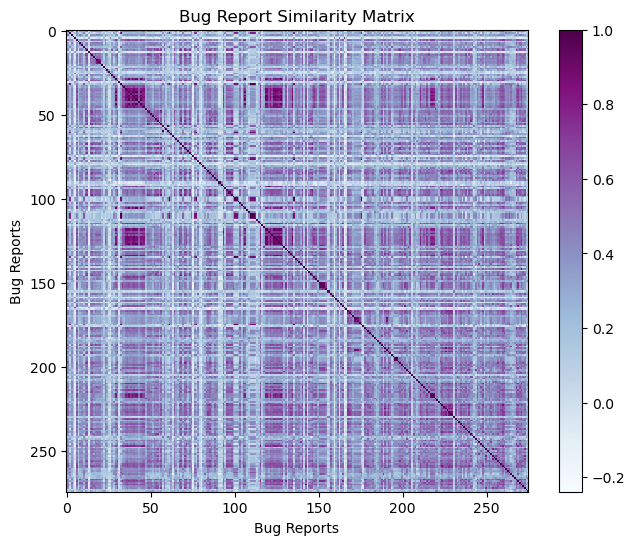

In [20]:


# Assuming your similarity matrix is named 'similarity_matrix'
# Replace this with your actual similarity matrix

# Plotting the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(similarity_Matrix, cmap='BuPu', interpolation='nearest')
plt.colorbar()  # Add color bar to show the scale
plt.title('Bug Report Similarity Matrix')
plt.xlabel('Bug Reports')
plt.ylabel('Bug Reports')
plt.show()

# Refactoring

### Creating functions to test with different parameters

In [22]:
def getDuplicateBugIDS(threshold_value,topic_x_df): 
    import torch
    model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
    # Encode sentences and store the embeddings in the DataFrame
    topic_x_df['embeddings'] = topic_x_df['full_text_data'].apply(lambda x: model.encode(x, convert_to_tensor=True))
    # Convert embeddings to a tensor
    embeddings = torch.stack(topic_x_df['embeddings'].tolist())
    # Calculate cosine similarity
    cosine_scores = util.pytorch_cos_sim(embeddings, embeddings)
    numpy_array = cosine_scores.numpy()
    # Reshape the NumPy array into a matrix
    similarity_Matrix= numpy_array.reshape(cosine_scores.shape)
    similarity_Matrix= np.round(similarity_Matrix, decimals=4)
    # Function to filter rows based on condition
    def filter_matrix(matrix, threshold):
        filtered_matrix = []
        for row in matrix:
            if np.any((row > threshold) & (row < 1)): #<1 to igorne the sim. with itself 
                filtered_matrix.append(row)
        return np.array(filtered_matrix)
    # Filtering the matrix
    filtered_matrix = filter_matrix(similarity_Matrix, threshold_value)
    n = 0 #to iterate through
    topic_x_df['Experimental_Duplicate_ID'] = np.nan  #intailly sets everything to null
    while n < filtered_matrix.shape[0]:  # number of rows do this process to each row 
        matrix = filtered_matrix[n]
        def find_position(matrix):  # finds position (index) of bug all other bugs are comparing to
            result = np.where(matrix == 1.0)
            return result[0][0]  # Extract the first index directly
    
        def get_duplicate_ids_index(matrix):  # finds index where there are most similar bugs to the bug at find_position
            condition = np.logical_and(matrix > threshold_value, matrix < 1)
            indices = np.argwhere(condition)
            return indices
        def get_duplicate_ids(matrix_indexs_of_duplicates):
            duplicate_ids = ""
            for row in matrix_indexs_of_duplicates:
                for element in row:
                    specific_row = topic_x_df.iloc[element]
                    duplicate_ids = duplicate_ids + " " + str(specific_row['Issue_id'])
            return duplicate_ids
        index_in_df = find_position(matrix)  # index of selected bug
        specific_row = topic_x_df.iloc[index_in_df]  # selects bug row in dataframe
        duplicateIDs_index_in_df = get_duplicate_ids_index(matrix)  # index of duplicate bugs
        topic_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)
        n += 1  # to go through each row in the matrix
    return topic_x_df['Experimental_Duplicate_ID']

In [23]:
def accuracy(topic_x_df):
    #a match is considered if there are any matching values in exp_ids and dup_ids 
       # Split the IDs by spaces and strip whitespace
    topic_x_df.fillna(0,inplace=True) #fills with zeros for new column 
    exp_ids = topic_x_df['Experimental_Duplicate_ID'].astype(str).str.split().apply(lambda x: [i.strip() for i in x])
    dup_ids = topic_x_df['Duplicated_issue'].astype(str).str.split().apply(lambda x: [i.strip() for i in x])
    
    # Convert all elements to strings to ensure consistent comparison
    exp_ids = exp_ids.apply(lambda x: [float(i) for i in x])
    dup_ids = dup_ids.apply(lambda x: [float(i) for i in x])
    # Check for any matches for each row
    matches = exp_ids.combine(dup_ids, lambda exp_list, dup_list: any(dup_id in exp_list for dup_id in dup_list))
    
    # Count the number of matches
    num_matches = matches.sum()
    accuracy=num_matches/len(topic_x_df)
    return accuracy

In [24]:
def precision(topic_x_df):
    topic_x_df.fillna(0,inplace=True) #fills with zeros for new column 
    exp_ids = topic_x_df['Experimental_Duplicate_ID'].astype(str).str.split().apply(lambda x: [i.strip() for i in x])
    dup_ids = topic_x_df['Duplicated_issue'].astype(str).str.split().apply(lambda x: [i.strip() for i in x])
    
    # Convert all elements to strings to ensure consistent comparison
    exp_ids = exp_ids.apply(lambda x: [float(i) for i in x])
    dup_ids = dup_ids.apply(lambda x: [float(i) for i in x])
    # Check for any matches for each row
    matches = exp_ids.combine(dup_ids, lambda exp_list, dup_list: any(dup_id in exp_list for dup_id in dup_list))
    
    # Count the number of matches which is when the experiment and actual match aka true positive
    truePositive = matches.sum()
    #falsePositive is when the experimental duplicate id has a number but the actual one doesn't
    falsePositives = ((topic_x_df['Duplicated_issue'] == 0) & (topic_x_df['Experimental_Duplicate_ID'] != 0)).sum()
    precison= truePositive/(truePositive+falsePositives)
    return precison
    

In [25]:
def recall(topic_x_df):
    topic_x_df.fillna(0,inplace=True) #fills with zeros for new column 
    exp_ids = topic_x_df['Experimental_Duplicate_ID'].astype(str).str.split().apply(lambda x: [i.strip() for i in x])
    dup_ids = topic_x_df['Duplicated_issue'].astype(str).str.split().apply(lambda x: [i.strip() for i in x])
    
    # Convert all elements to strings to ensure consistent comparison
    exp_ids = exp_ids.apply(lambda x: [float(i) for i in x])
    dup_ids = dup_ids.apply(lambda x: [float(i) for i in x])
    # Check for any matches for each row
    matches = exp_ids.combine(dup_ids, lambda exp_list, dup_list: any(dup_id in exp_list for dup_id in dup_list))
    
    # Count the number of matches which is when the experiment and actual match aka true positive
    truePositive = matches.sum()

    # Convert columns to sets
    experimental_set = set(topic_x_df['Experimental_Duplicate_ID'])
    actual_set = set(topic_x_df['Duplicated_issue'])

    # Identify False Negatives
    falseNegatives = actual_set - experimental_set
    falseNegativesCount=len(list(falseNegatives))
    recall=truePositive/(truePositive+falseNegativesCount)
    return recall

In [26]:
def f1(topic_x_df):
    recallVal=recall(topic_x_df)
    precisionVal=precision(topic_x_df)
    f1=2*((recallVal*precisionVal)/(precisionVal+recallVal))
    return f1

In [27]:
def experimentalisDuplicate(topic_x_df): #creates column for experimental binary isDuplciates
    def is_duplicate(val):
        return 1 if val !=(0.0 or 0) else 0
    topic_x_df['isExperimentalDuplicate'] = topic_x_df['Experimental_Duplicate_ID'].apply(lambda x: is_duplicate(x))
    return topic_x_df['isExperimentalDuplicate']

In [28]:
def binaryAccuracy(topic_x_df): #see if the ones and zeros match, different from other acuracy becuase that one can have only one element mathc and it count ex bug 1 has ids 1234 and 8472 it should still count as a duplciate to bug 2 with 1234 0889 
    matches=topic_x_df['isExperimentalDuplicate']==topic_x_df['isDuplicate']
    num_matches=matches.sum()
    accuracy=num_matches/len(topic_x_df['isExperimentalDuplicate'])
    return accuracy

 # Testing different thersholds 

In [29]:
# Initialize lists to store the results
#for 85% similarity b
accuracy_values_85 = []
binary_accuracy_values_85 = []
recall_values_85 = []
precision_values_85 = []
f1_values_85 = []
topic_dfs = [topic_0_df, topic_1_df, topic_2_df, topic_3_df, topic_4_df, topic_5_df, topic_6_df]
# Perform the analysis and store the results
for x in range(7):
    df = topic_dfs[x]

    df['Experimental_Duplicate_ID'] = getDuplicateBugIDS(0.85, df)
    accuracyVal = accuracy(df) * 100
    accuracy_values_85.append(accuracyVal)
    print(f"Accuracy for topic {x} for matching id is %{accuracyVal:.2f}")

    experimentalisDuplicate(df)
    binaryAccuracyVal = binaryAccuracy(df) * 100
    binary_accuracy_values_85.append(binaryAccuracyVal)
    print(f"Accuracy for topic {x} for duplicate or not is %{binaryAccuracyVal:.2f}")

    recallVal = recall(df) * 100
    recall_values_85.append(recallVal)
    print(f"Recall for topic {x} is %{recallVal:.2f}")

    precisionVal = precision(df) * 100
    precision_values_85.append(precisionVal)
    print(f"Precision for topic {x} is %{precisionVal:.2f}")

    f1Val = f1(df) * 100
    f1_values_85.append(f1Val)
    print(f"F1 score for topic {x} is %{f1Val:.2f}")


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_124509/4082931334.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 0 for matching id is %69.09
Accuracy for topic 0 for duplicate or not is %70.18
Recall for topic 0 is %86.36
Precision for topic 0 is %79.17
F1 score for topic 0 is %82.61


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_124509/4082931334.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 1 for matching id is %74.45
Accuracy for topic 1 for duplicate or not is %76.51
Recall for topic 1 is %85.94
Precision for topic 1 is %86.17
F1 score for topic 1 is %86.05


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_124509/4082931334.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 2 for matching id is %83.98
Accuracy for topic 2 for duplicate or not is %84.38
Recall for topic 2 is %89.33
Precision for topic 2 is %95.33
F1 score for topic 2 is %92.24


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_124509/4082931334.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 3 for matching id is %54.78
Accuracy for topic 3 for duplicate or not is %64.21
Recall for topic 3 is %75.80
Precision for topic 3 is %81.67
F1 score for topic 3 is %78.63


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_124509/4082931334.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 4 for matching id is %52.55
Accuracy for topic 4 for duplicate or not is %61.47
Recall for topic 4 is %74.89
Precision for topic 4 is %69.84
F1 score for topic 4 is %72.28


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_124509/4082931334.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 5 for matching id is %79.32
Accuracy for topic 5 for duplicate or not is %79.58
Recall for topic 5 is %85.47
Precision for topic 5 is %97.77
F1 score for topic 5 is %91.20


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_124509/4082931334.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 6 for matching id is %82.75
Accuracy for topic 6 for duplicate or not is %82.98
Recall for topic 6 is %88.23
Precision for topic 6 is %98.28
F1 score for topic 6 is %92.99


In [47]:

accuracyAverageVal85=statistics.mean(accuracy_values_85)
binaryAccuracyAverageVal85=statistics.mean(binary_accuracy_values_85)
recallAverageVal85=statistics.mean(recall_values_85)
precisionAverageVal85=statistics.mean(precision_values_85)
f1AverageVal85=statistics.mean(f1_values_85)

print("The average accuracy for 85% similarity is: "+ str(accuracyAverageVal85))
print("The average binary accuracy for 85% similarity is: "+ str(binaryAccuracyAverageVal85))
print("The average recall accuracy for 85% similarity is:"+ str(recallAverageVal85))
print("The average precision accuracy for 85% similarity is:"+ str(precisionAverageVal85))
print("The average f1 score accuracy for 85% similarity is:"+ str(f1AverageVal85))

The average accuracy for 85% similarity is: 70.98764493650057
The average binary accuracy for 85% similarity is: 74.18618688263034
The average recall accuracy for 85% similarity is:83.71839799954952
The average precision accuracy for 85% similarity is:86.8901106502925
The average f1 score accuracy for 85% similarity is:85.14214113112307


In [32]:
# Initialize lists to store the results
#for 75% similarity b
accuracy_values_75 = []
binary_accuracy_values_75 = []
recall_values_75 = []
precision_values_75 = []
f1_values_75 = []
topic_dfs = [topic_0_df, topic_1_df, topic_2_df, topic_3_df, topic_4_df, topic_5_df, topic_6_df]
# Perform the analysis and store the results
for x in range(7):
    df = topic_dfs[x]

    df['Experimental_Duplicate_ID'] = getDuplicateBugIDS(0.75, df)
    accuracyVal = accuracy(df) * 100
    accuracy_values_75.append(accuracyVal)
    print(f"Accuracy for topic {x} for matching id is %{accuracyVal:.2f}")

    experimentalisDuplicate(df)
    binaryAccuracyVal = binaryAccuracy(df) * 100
    binary_accuracy_values_75.append(binaryAccuracyVal)
    print(f"Accuracy for topic {x} for duplicate or not is %{binaryAccuracyVal:.2f}")

    recallVal = recall(df) * 100
    recall_values_75.append(recallVal)
    print(f"Recall for topic {x} is %{recallVal:.2f}")

    precisionVal = precision(df) * 100
    precision_values_75.append(precisionVal)
    print(f"Precision for topic {x} is %{precisionVal:.2f}")

    f1Val = f1(df) * 100
    f1_values_75.append(f1Val)
    print(f"F1 score for topic {x} is %{f1Val:.2f}")


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_124509/4082931334.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 0 for matching id is %52.36
Accuracy for topic 0 for duplicate or not is %55.64
Recall for topic 0 is %82.76
Precision for topic 0 is %59.50
F1 score for topic 0 is %69.23


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_124509/4082931334.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 1 for matching id is %47.17
Accuracy for topic 1 for duplicate or not is %53.69
Recall for topic 1 is %79.48
Precision for topic 1 is %54.08
F1 score for topic 1 is %64.37


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_124509/4082931334.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 2 for matching id is %69.44
Accuracy for topic 2 for duplicate or not is %71.99
Recall for topic 2 is %87.38
Precision for topic 2 is %78.58
F1 score for topic 2 is %82.75


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_124509/4082931334.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 3 for matching id is %29.92
Accuracy for topic 3 for duplicate or not is %51.50
Recall for topic 3 is %63.11
Precision for topic 3 is %43.03
F1 score for topic 3 is %51.17


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_124509/4082931334.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 4 for matching id is %23.41
Accuracy for topic 4 for duplicate or not is %39.92
Recall for topic 4 is %57.05
Precision for topic 4 is %30.01
F1 score for topic 4 is %39.34


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_124509/4082931334.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 5 for matching id is %68.11
Accuracy for topic 5 for duplicate or not is %71.49
Recall for topic 5 is %83.47
Precision for topic 5 is %83.40
F1 score for topic 5 is %83.44


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_124509/4082931334.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 6 for matching id is %67.68
Accuracy for topic 6 for duplicate or not is %71.69
Recall for topic 6 is %85.98
Precision for topic 6 is %79.83
F1 score for topic 6 is %82.79


In [46]:

accuracyAverageVal75=statistics.mean(accuracy_values_75)
binaryAccuracyAverageVal75=statistics.mean(binary_accuracy_values_75)
recallAverageVal75=statistics.mean(recall_values_75)
precisionAverageVal75=statistics.mean(precision_values_75)
f1AverageVal75=statistics.mean(f1_values_75)

print("The average accuracy for 75% similarity is: "+ str(accuracyAverageVal75))
print("The average binary accuracy for 75% similarity is: "+ str(binaryAccuracyAverageVal75))
print("The average recall accuracy for 75% similarity is:"+ str(recallAverageVal75))
print("The average precision accuracy for 75% similarity is:"+ str(precisionAverageVal75))
print("The average f1 score accuracy for 75% similarity is:"+ str(f1AverageVal75))

The average accuracy for 75% similarity is: 51.15621379860233
The average binary accuracy for 75% similarity is: 59.417955122157295
The average recall accuracy for 75% similarity is:77.03392080155122
The average precision accuracy for 75% similarity is:61.20610075633599
The average f1 score accuracy for 75% similarity is:67.58257310758218


In [34]:
# Initialize lists to store the results
#for 95% similarity b
accuracy_values_95 = []
binary_accuracy_values_95 = []
recall_values_95 = []
precision_values_95 = []
f1_values_95 = []
topic_dfs = [topic_0_df, topic_1_df, topic_2_df, topic_3_df, topic_4_df, topic_5_df, topic_6_df]
# Perform the analysis and store the results
for x in range(7):
    df = topic_dfs[x]

    df['Experimental_Duplicate_ID'] = getDuplicateBugIDS(0.95, df)
    accuracyVal = accuracy(df) * 100
    accuracy_values_95.append(accuracyVal)
    print(f"Accuracy for topic {x} for matching id is %{accuracyVal:.2f}")

    experimentalisDuplicate(df)
    binaryAccuracyVal = binaryAccuracy(df) * 100
    binary_accuracy_values_95.append(binaryAccuracyVal)
    print(f"Accuracy for topic {x} for duplicate or not is %{binaryAccuracyVal:.2f}")

    recallVal = recall(df) * 100
    recall_values_95.append(recallVal)
    print(f"Recall for topic {x} is %{recallVal:.2f}")

    precisionVal = precision(df) * 100
    precision_values_95.append(precisionVal)
    print(f"Precision for topic {x} is %{precisionVal:.2f}")

    f1Val = f1(df) * 100
    f1_values_95.append(f1Val)
    print(f"F1 score for topic {x} is %{f1Val:.2f}")


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_124509/4082931334.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 0 for matching id is %82.18
Accuracy for topic 0 for duplicate or not is %82.18
Recall for topic 0 is %88.28
Precision for topic 0 is %94.56
F1 score for topic 0 is %91.31


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_124509/4082931334.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 1 for matching id is %83.59
Accuracy for topic 1 for duplicate or not is %83.81
Recall for topic 1 is %87.28
Precision for topic 1 is %97.30
F1 score for topic 1 is %92.02


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_124509/4082931334.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 2 for matching id is %87.58
Accuracy for topic 2 for duplicate or not is %87.72
Recall for topic 2 is %89.72
Precision for topic 2 is %99.54
F1 score for topic 2 is %94.38


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_124509/4082931334.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 3 for matching id is %64.62
Accuracy for topic 3 for duplicate or not is %65.57
Recall for topic 3 is %78.70
Precision for topic 3 is %97.33
F1 score for topic 3 is %87.03


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_124509/4082931334.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 4 for matching id is %71.55
Accuracy for topic 4 for duplicate or not is %72.39
Recall for topic 4 is %80.24
Precision for topic 4 is %96.97
F1 score for topic 4 is %87.81


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_124509/4082931334.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 5 for matching id is %80.44
Accuracy for topic 5 for duplicate or not is %80.48
Recall for topic 5 is %85.64
Precision for topic 5 is %99.34
F1 score for topic 5 is %91.98


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_124509/4082931334.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 6 for matching id is %83.79
Accuracy for topic 6 for duplicate or not is %83.83
Recall for topic 6 is %88.36
Precision for topic 6 is %99.61
F1 score for topic 6 is %93.65


In [45]:

accuracyAverageVal95=statistics.mean(accuracy_values_95)
binaryAccuracyAverageVal95=statistics.mean(binary_accuracy_values_95)
recallAverageVal95=statistics.mean(recall_values_95)
precisionAverageVal95=statistics.mean(precision_values_95)
f1AverageVal95=statistics.mean(f1_values_95)

print("The average accuracy for 95% similarity is: "+ str(accuracyAverageVal95))
print("The average binary accuracy for 95% similarity is: "+ str(binaryAccuracyAverageVal95))
print("The average recall accuracy for 95% similarity is:"+ str(recallAverageVal95))
print("The average precision accuracy for 95% similarity is:"+ str(precisionAverageVal95))
print("The average f1 score accuracy for 95% similarity is:"+ str(f1AverageVal95))

The average accuracy for 95% similarity is: 79.10673557245147
The average binary accuracy for 95% similarity is: 79.4272795928218
The average recall accuracy for 95% similarity is:85.4621756362765
The average precision accuracy for 95% similarity is:97.80595248203149
The average f1 score accuracy for 95% similarity is:91.16943676328859


In [37]:
# Initialize lists to store the results
#for 80% similarity b
accuracy_values_80 = []
binary_accuracy_values_80 = []
recall_values_80 = []
precision_values_80 = []
f1_values_80 = []
topic_dfs = [topic_0_df, topic_1_df, topic_2_df, topic_3_df, topic_4_df, topic_5_df, topic_6_df]
# Perform the analysis and store the results
for x in range(7):
    df = topic_dfs[x]

    df['Experimental_Duplicate_ID'] = getDuplicateBugIDS(0.80, df)
    accuracyVal = accuracy(df) * 100
    accuracy_values_80.append(accuracyVal)
    print(f"Accuracy for topic {x} for matching id is %{accuracyVal:.2f}")

    experimentalisDuplicate(df)
    binaryAccuracyVal = binaryAccuracy(df) * 100
    binary_accuracy_values_80.append(binaryAccuracyVal)
    print(f"Accuracy for topic {x} for duplicate or not is %{binaryAccuracyVal:.2f}")

    recallVal = recall(df) * 100
    recall_values_80.append(recallVal)
    print(f"Recall for topic {x} is %{recallVal:.2f}")

    precisionVal = precision(df) * 100
    precision_values_80.append(precisionVal)
    print(f"Precision for topic {x} is %{precisionVal:.2f}")

    f1Val = f1(df) * 100
    f1_values_80.append(f1Val)
    print(f"F1 score for topic {x} is %{f1Val:.2f}")

/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_124509/4082931334.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 0 for matching id is %63.64
Accuracy for topic 0 for duplicate or not is %65.45
Recall for topic 0 is %85.37
Precision for topic 0 is %72.31
F1 score for topic 0 is %78.30


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_124509/4082931334.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 1 for matching id is %62.76
Accuracy for topic 1 for duplicate or not is %67.03
Recall for topic 1 is %83.75
Precision for topic 1 is %72.26
F1 score for topic 1 is %77.58


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_124509/4082931334.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 2 for matching id is %79.16
Accuracy for topic 2 for duplicate or not is %80.23
Recall for topic 2 is %88.75
Precision for topic 2 is %89.78
F1 score for topic 2 is %89.27


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_124509/4082931334.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 3 for matching id is %41.94
Accuracy for topic 3 for duplicate or not is %58.47
Recall for topic 3 is %70.57
Precision for topic 3 is %61.77
F1 score for topic 3 is %65.88


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_124509/4082931334.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 4 for matching id is %36.47
Accuracy for topic 4 for duplicate or not is %49.91
Recall for topic 4 is %67.42
Precision for topic 4 is %47.59
F1 score for topic 4 is %55.80


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_124509/4082931334.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 5 for matching id is %76.68
Accuracy for topic 5 for duplicate or not is %77.65
Recall for topic 5 is %85.04
Precision for topic 5 is %94.31
F1 score for topic 5 is %89.44


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_124509/4082931334.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 6 for matching id is %79.12
Accuracy for topic 6 for duplicate or not is %80.40
Recall for topic 6 is %87.76
Precision for topic 6 is %93.79
F1 score for topic 6 is %90.68


In [44]:

accuracyAverageVal80=statistics.mean(accuracy_values_80)
binaryAccuracyAverageVal80=statistics.mean(binary_accuracy_values_80)
recallAverageVal80=statistics.mean(recall_values_80)
precisionAverageVal80=statistics.mean(precision_values_80)
f1AverageVal80=statistics.mean(f1_values_80)

print("The average accuracy for 80% similarity is: "+ str(accuracyAverageVal80))
print("The average binary accuracy for 80% similarity is: "+ str(binaryAccuracyAverageVal80))
print("The average recall accuracy for 80% similarity is:"+ str(recallAverageVal80))
print("The average precision accuracy for 80% similarity is:"+ str(precisionAverageVal80))
print("The average f1 score accuracy for 80% similarity is:"+ str(f1AverageVal80))

The average accuracy for 80% similarity is: 62.82218002637716
The average binary accuracy for 80% similarity is: 68.44931811969391
The average recall accuracy for 80% similarity is:81.23838137160269
The average precision accuracy for 80% similarity is:75.97500618033928
The average f1 score accuracy for 80% similarity is:78.13397804385697


In [40]:
# Initialize lists to store the results
#for 80% similarity b
accuracy_values_90 = []
binary_accuracy_values_90 = []
recall_values_90 = []
precision_values_90 = []
f1_values_90 = []
topic_dfs = [topic_0_df, topic_1_df, topic_2_df, topic_3_df, topic_4_df, topic_5_df, topic_6_df]
# Perform the analysis and store the results
for x in range(7):
    df = topic_dfs[x]

    df['Experimental_Duplicate_ID'] = getDuplicateBugIDS(0.90, df)
    accuracyVal = accuracy(df) * 100
    accuracy_values_90.append(accuracyVal)
    print(f"Accuracy for topic {x} for matching id is %{accuracyVal:.2f}")

    experimentalisDuplicate(df)
    binaryAccuracyVal = binaryAccuracy(df) * 100
    binary_accuracy_values_90.append(binaryAccuracyVal)
    print(f"Accuracy for topic {x} for duplicate or not is %{binaryAccuracyVal:.2f}")

    recallVal = recall(df) * 100
    recall_values_90.append(recallVal)
    print(f"Recall for topic {x} is %{recallVal:.2f}")

    precisionVal = precision(df) * 100
    precision_values_90.append(precisionVal)
    print(f"Precision for topic {x} is %{precisionVal:.2f}")

    f1Val = f1(df) * 100
    f1_values_90.append(f1Val)
    print(f"F1 score for topic {x} is %{f1Val:.2f}")

/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_124509/4082931334.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 0 for matching id is %74.55
Accuracy for topic 0 for duplicate or not is %74.91
Recall for topic 0 is %87.23
Precision for topic 0 is %85.42
F1 score for topic 0 is %86.32


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_124509/4082931334.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 1 for matching id is %80.10
Accuracy for topic 1 for duplicate or not is %80.85
Recall for topic 1 is %86.80
Precision for topic 1 is %92.92
F1 score for topic 1 is %89.76


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_124509/4082931334.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 2 for matching id is %86.54
Accuracy for topic 2 for duplicate or not is %86.77
Recall for topic 2 is %89.61
Precision for topic 2 is %98.32
F1 score for topic 2 is %93.76


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_124509/4082931334.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 3 for matching id is %61.89
Accuracy for topic 3 for duplicate or not is %65.03
Recall for topic 3 is %77.97
Precision for topic 3 is %92.83
F1 score for topic 3 is %84.75


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_124509/4082931334.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 4 for matching id is %64.99
Accuracy for topic 4 for duplicate or not is %68.73
Recall for topic 4 is %78.67
Precision for topic 4 is %87.45
F1 score for topic 4 is %82.83


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_124509/4082931334.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 5 for matching id is %80.07
Accuracy for topic 5 for duplicate or not is %80.20
Recall for topic 5 is %85.58
Precision for topic 5 is %98.79
F1 score for topic 5 is %91.72


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_124509/4082931334.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 6 for matching id is %83.49
Accuracy for topic 6 for duplicate or not is %83.56
Recall for topic 6 is %88.33
Precision for topic 6 is %99.22
F1 score for topic 6 is %93.46


In [43]:

accuracyAverageVal90=statistics.mean(accuracy_values_90)
binaryAccuracyAverageVal90=statistics.mean(binary_accuracy_values_90)
recallAverageVal90=statistics.mean(recall_values_90)
precisionAverageVal90=statistics.mean(precision_values_90)
f1AverageVal90=statistics.mean(f1_values_90)

print("The average accuracy for 90% similarity is: "+ str(accuracyAverageVal90))
print("The average binary accuracy for 90% similarity is: "+ str(binaryAccuracyAverageVal90))
print("The average recall accuracy for 90% similarity is:"+ str(recallAverageVal90))
print("The average precision accuracy for 90% similarity is:"+ str(precisionAverageVal90))
print("The average f1 score accuracy for 90% similarity is:"+ str(f1AverageVal90))

The average accuracy for 90% similarity is: 75.94528646137935
The average binary accuracy for 90% similarity is: 77.15084843043408
The average recall accuracy for 90% similarity is:84.88565086083533
The average precision accuracy for 90% similarity is:93.56469929924292
The average f1 score accuracy for 90% similarity is:88.94178568199357


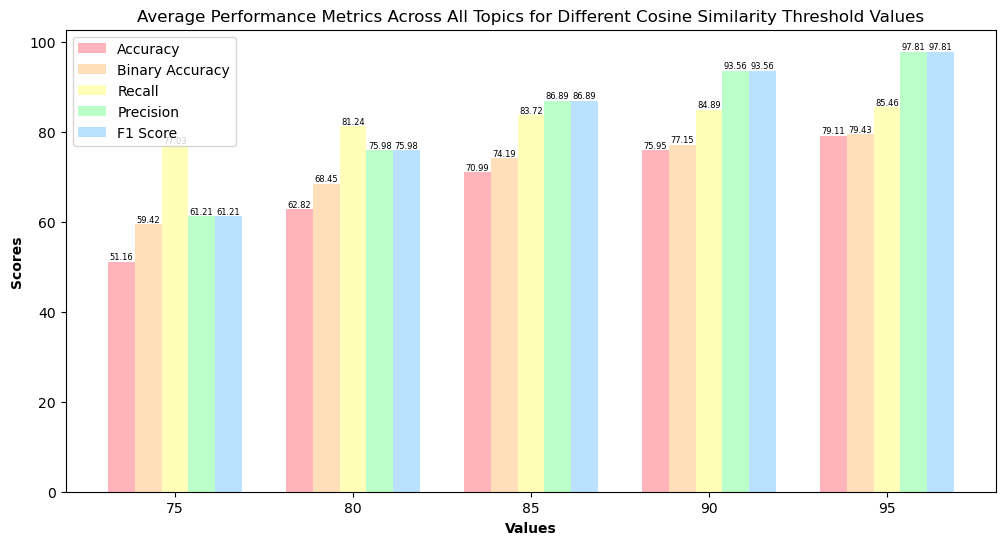

In [61]:
import matplotlib.pyplot as plt

# Provided values for each metric at different points
metrics = {
    'accuracyAverageVal': [accuracyAverageVal75, accuracyAverageVal80, accuracyAverageVal85, accuracyAverageVal90, accuracyAverageVal95],
    'binaryAccuracyAverageVal': [binaryAccuracyAverageVal75, binaryAccuracyAverageVal80, binaryAccuracyAverageVal85, binaryAccuracyAverageVal90, binaryAccuracyAverageVal95],
    'recallAverageVal': [recallAverageVal75, recallAverageVal80, recallAverageVal85, recallAverageVal90, recallAverageVal95],
    'precisionAverageVal': [precisionAverageVal75, precisionAverageVal80, precisionAverageVal85, precisionAverageVal90, precisionAverageVal95],
    'f1AverageVal': [precisionAverageVal75, precisionAverageVal80, precisionAverageVal85, precisionAverageVal90, precisionAverageVal95]
}

categories = ['75', '80', '85', '90', '95']
bar_width = 0.15

# Positions of the bars on the x-axis
r1 = range(len(categories))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
r5 = [x + bar_width for x in r4]

colors = ['#FFB3BA', '#FFDFBA', '#FFFFBA', '#BAFFC9', '#BAE1FF']

# Create the bars
plt.figure(figsize=(12, 6))
bars1 = plt.bar(r1, metrics['accuracyAverageVal'], color=colors[0], width=bar_width, label='Accuracy')
bars2 = plt.bar(r2, metrics['binaryAccuracyAverageVal'], color=colors[1], width=bar_width, label='Binary Accuracy')
bars3 = plt.bar(r3, metrics['recallAverageVal'], color=colors[2], width=bar_width, label='Recall')
bars4 = plt.bar(r4, metrics['precisionAverageVal'], color=colors[3], width=bar_width, label='Precision')
bars5 = plt.bar(r5, metrics['f1AverageVal'], color=colors[4], width=bar_width, label='F1 Score')

# Add labels
plt.xlabel('Values', fontweight='bold')
plt.ylabel('Scores', fontweight='bold')
plt.xticks([r + 2 * bar_width for r in range(len(categories))], categories)
plt.legend()

# Add value labels to bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom',fontsize=6)

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)
add_labels(bars4)
add_labels(bars5)

# Title
plt.title('Average Performance Metrics Across All Topics for Different Cosine Similarity Threshold Values')

# Show plot
plt.show()

